In [5]:
#importing all required packages in at once
import nltk
import pandas as pd
import csv
import re
import numpy as np
import os
import gensim
import pattern
import glob
import matplotlib.pyplot
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import ngrams
from gensim import corpora, models

In [6]:
#Generate file names using glob
_2018filenames = [I for I in glob.glob('data/2018/*.txt')]
_2019filenames = [I for I in glob.glob('data/2019/*.txt')]
_2020filenames = [I for I in glob.glob('data/2020/*.txt')]
_2021filenames = [I for I in glob.glob('data/2021/*.txt')]
_2022filenames = [I for I in glob.glob('data/2022/*.txt')]

#TO REMOVE: TEST CASE FOR BIGRAMS
# test_data = open(r"./data/TEST1.txt", "r").read()
# list_test = list()
# list_test.append(test_data)

#Save the 
list_2018 = list()

list_2019 = list()

list_2020 = list()

list_2021 = list()

list_2022 = list()

for file in _2018filenames:
    case = open(r"" + file + "", "r")
    list_2018.append(case)

for file in _2019filenames:
    case = open(r"" + file + "", "r")
    list_2019.append(case)

for file in _2020filenames:
    case = open(r"" + file + "", "r")
    list_2020.append(case)

for file in _2021filenames:
    case = open(r"" + file + "", "r")
    list_2021.append(case)

for file in _2022filenames:
    case = open(r"" + file + "", "r")
    list_2022.append(case)

#Print lengths
print("There are " + str(len(list_2018)) + " CEQA cases to analyze in 2018.")
print("There are " + str(len(list_2019)) + " CEQA cases to analyze in 2019.")
print("There are " + str(len(list_2020)) + " CEQA cases to analyze in 2020.")
print("There are " + str(len(list_2021)) + " CEQA cases to analyze in 2021.")
print("There are " + str(len(list_2022)) + " CEQA cases to analyze in 2022.")


There are 217 CEQA cases to analyze in 2018.
There are 235 CEQA cases to analyze in 2019.
There are 192 CEQA cases to analyze in 2020.
There are 211 CEQA cases to analyze in 2021.
There are 116 CEQA cases to analyze in 2022.


In [7]:
#Import default NLTK stopwords
from nltk.corpus import stopwords
#Add more stopwords
adtl_stopwords = pd.read_csv("./preprocessing/test_stopwords.csv", header = None)
adtl_stopwords = adtl_stopwords.values.tolist()
adtl_stopwords = adtl_stopwords[0]

#Combine with default stopwords list
stopwords_def = stopwords.words('english')
stopwords_def.extend(adtl_stopwords)
print(stopwords_def)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
from pattern.en import singularize
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

for i in range(len(list_2018)):

    #Step 1: RegEx processing
    
    #Read in the data as 'read'
    draft_case = list_2018[i].read()
   
    ##Use regex to do a preliminary cleaning of the content
    ### Remove punctuation and numbers
    draft_case = re.sub("[0-9]", "", draft_case) #Removes numbers
    draft_case = re.sub(r"\/", " ", draft_case) #Replaces slashes with spaces
    draft_case = re.sub(r"\'", " ", draft_case) #Replaces apostrophes with spaces
    draft_case = re.sub(r"\-", " ", draft_case) #Replaces en-dash with spaces
    draft_case = re.sub(r"\–", " ", draft_case) #Replaces em-dash with spaces
    draft_case = re.sub(r"[.,?!()•$;:@§%&~\[\]\"]", "", draft_case) #Removes extraneous punctuation
    draft_case = re.sub(r"^$n','\n", "", draft_case, re.MULTILINE) #Removes empty lines
    draft_case = re.sub(r"\b\w{1,2}\b", '', draft_case) #Removes all one and two-character words (none have meaning)
    draft_case = re.sub(r"\n","", draft_case) #Removes extraneous line breaks
    
    #Remove extraneous information about lawyers and case detail that doesn't impact the content of the case
    starting_phrase = "PRELIMINARY STATEMENT" #Use this as the starter for when the actual lawsuit begins
    remove_before = r'^.*?{}'.format(re.escape(starting_phrase))
    draft_case = re.sub(remove_before, "", draft_case, flags=re.DOTALL)
    
    #Remove "FIRST AMENDED COMPLAINT", which is at the bottom of every page
    draft_case = re.sub(r"FIRST AMENDED COMPLAINT", "", draft_case)
    
    #These steps are done last since other words' removal will impact them
    draft_case = re.sub(r"\s+", " ", draft_case) #Removes multiple whitespaces
    draft_case = re.sub(r"([a-z])([A-Z])", r"\1 \2", draft_case) #Separates words that were joined together by double spaces

    #Step 2: Stopword removal
    def remove_stopwords(text):
        return [[word for word in draft_case
             if word not in stopwords_def] for doc in texts]
    
    #Step 3: Tokenization and singularization
    
    #Word tokenization
    draft_case = word_tokenize(draft_case)
    
    #Depluralize all nouns
    #Find words that end with 's' that need to be handled differently than plurals
    exceptions = pd.read_csv('./preprocessing/singularized_exceptions.csv')
    exceptions_list = exceptions.to_dict('records')
    exceptions_list = exceptions_list[0]
    
    #Set a function to process these words differently
    def singularize_esp(word):
        if word in exceptions_list:
            return exceptions_list.get(word)
        return singularize(word)
    
    draft_case = [singularize_esp(word) for word in draft_case]

    #Step 3: Remove all non-real words

    #Define words as anything distinct in these two NLTK sets
    real_word_set = set(words.words() + list(wordnet.words()))
    
    #Want to keep certain words capitalized
    proper_nouns = pd.read_csv('./preprocessing/proper_nouns.csv', header = None)
    proper_nouns = proper_nouns.values.tolist()
    proper_nouns = proper_nouns[0]
    
    def recapitalize(word):
        if word in proper_nouns:
            return word
        if word.lower() in real_word_set:
            return word.lower()   
        else:
            return word
            
    draft_case = [recapitalize(word) for word in draft_case]
    
    draft_case = [word for word in draft_case if (word in real_word_set or word in proper_nouns)]

    #Step 4: implement n-grams
    draft_case = ' '.join(draft_case)
    ##Create n-grams using pointwise mutual information

    ###Create bigrams and use PMI to score them
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(str.split(draft_case))
    ####Apply a frequency filter
    bigram_finder.apply_freq_filter(15)
    bigram_scores = bigram_finder.score_ngrams(bigram_measures.pmi)
    
    ###Do the same for trigrams
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    trigram_finder = nltk.collocations.TrigramCollocationFinder.from_words(str.split(draft_case))
    ####Frequency filter
    trigram_finder.apply_freq_filter(15)
    trigram_scores = trigram_finder.score_ngrams(trigram_measures.pmi)
    
    #Store the scores as dataframes
    
    bigram_pmi = pd.DataFrame(bigram_scores)
    if bigram_pmi.empty == False:
        bigram_pmi.columns = ['bigram', 'pmi']
        bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    #Save only the bigrams with PMI greater than 5 (arbitrary threshold)
        bigram_pmi = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram.pmi > 4, axis = 1)][:500]
        bigrams = [' '.join(x) for x in bigram_pmi.bigram.values]

    trigram_pmi = pd.DataFrame(trigram_scores)
    if trigram_pmi.empty == False:
        trigram_pmi.columns = ['trigram', 'pmi']
        trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    #Save only the trigrams with PMI greater than 5 (arbitrary threshold)
        trigram_pmi = trigram_pmi[trigram_pmi.apply(lambda trigram: trigram.pmi > 4, axis = 1)][:500]
        trigrams = [' '.join(x) for x in trigram_pmi.trigram.values]

    # Concatenate n-grams
    def replace_ngram(x):
        for gram in bigrams:
            x = x.replace(gram, '_'.join(gram.split()))
        for gram in trigrams:
            x = x.replace(gram, '_'.join(gram.split()))
        return x
    
    draft_case = replace_ngram(draft_case)

    #Step 5: Lemmatize output
        
    #Re-tokenize
    draft_case = word_tokenize(draft_case)

    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    
    #Tag by part of speech
    
    tagged_word_content = pos_tag(draft_case)
    
    
    #Need to lemmatize using part of speech to ensure accuracy
    def pos_lemmatize(word, tag):
        if tag.startswith('J'):
            return lemmatizer.lemmatize(word, pos='a')  # Adjective
        elif tag.startswith('V'):
            return lemmatizer.lemmatize(word, pos='v')  # Verb
        elif tag.startswith('N'):
            return lemmatizer.lemmatize(word, pos='n')  # Noun
        elif tag.startswith('R'):
            return lemmatizer.lemmatize(word, pos='r')  # Adverb
        else:
            return lemmatizer.lemmatize(word)  # Default to noun
    
    # Lemmatize using part of speech
    lemmatized_output = [pos_lemmatize(word, tag) for word, tag in tagged_word_content]

    #Filter to keep only nouns
    def nouns(word):
        pos_word = nltk.pos_tag(word)
        filtered = [word[0] for word in pos_word if word[1] in ['NN', 'NNP', 'NNS', 'NNPS']]
        return filtered

    lemmatized_output = nouns(lemmatized_output)

    list_2018[i] = lemmatized_output
    

In [9]:
#import bag of words vectorization
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

dictionary_2018 = corpora.Dictionary(list_2018)
print("The dictionary has " +str(len(dictionary_2018)) + " tokens")

doc_term_matrix = [dictionary_2018.doc2bow(case) for case in list_2018]


The dictionary has 12118 tokens


In [10]:
#Find coherence for 2018 data
#Authorial note: As of right now, we are using Cv for coherence; after, we will review literature to find updated methodology

coherence_2018 = []
for k in range(5,25):
    print('Topic number: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary_2018, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=list_2018,\
                                                     dictionary=dictionary_2018, coherence='c_v')
    coherence_2018.append((k,cm.get_coherence()))

Topic number: 5
Topic number: 6
Topic number: 7
Topic number: 8
Topic number: 9
Topic number: 10
Topic number: 11
Topic number: 12
Topic number: 13
Topic number: 14
Topic number: 15
Topic number: 16
Topic number: 17
Topic number: 18
Topic number: 19
Topic number: 20
Topic number: 21
Topic number: 22
Topic number: 23
Topic number: 24


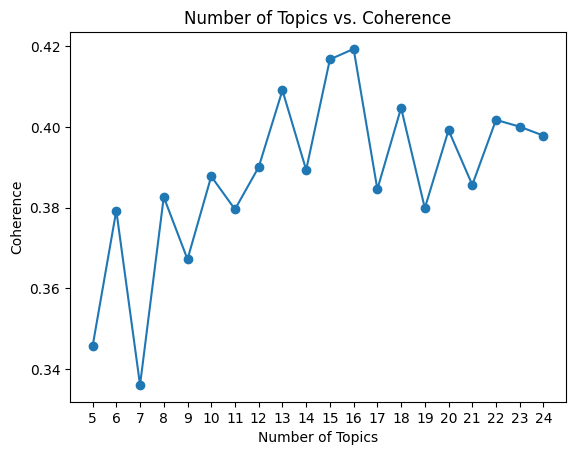

In [11]:
x_val = [x[0] for x in coherence_2018]
y_val = [x[1] for x in coherence_2018]
matplotlib.pyplot.plot(x_val,y_val)
matplotlib.pyplot.scatter(x_val,y_val)
matplotlib.pyplot.title('Number of Topics vs. Coherence')
matplotlib.pyplot.xlabel('Number of Topics')
matplotlib.pyplot.ylabel('Coherence')
matplotlib.pyplot.xticks(x_val)
matplotlib.pyplot.show()

#Most coherent at 10 topics and 23; let's run both as models

In [12]:
#10-topic

Lda_10 = gensim.models.ldamodel.LdaModel
ldamodel_10 = Lda_10(doc_term_matrix, num_topics=10, id2word = dictionary_2018, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

#23-topic

Lda_23 = gensim.models.ldamodel.LdaModel
ldamodel_23 = Lda_23(doc_term_matrix, num_topics=23, id2word = dictionary_2018, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [3]:
# To show initial topics
ldamodel_10.show_topics(10, num_words=10, formatted=False)
ldamodel_23.show_topics(23, num_words=10, formatted=False)

NameError: name 'ldamodel_10' is not defined